In [1]:
import json
import flax
import flax.linen as nn
from flax.training import train_state
from flax.training import common_utils
from flax import jax_utils
import jax
import jax.numpy as jnp
import optax
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from typing import Any, Callable, Sequence, Tuple
from functools import partial
from absl import logging
from tqdm import tqdm

%matplotlib inline

In [2]:
logging.set_verbosity(logging.INFO)

#### list devices

In [3]:
jax.devices()

INFO:absl:Starting the local TPU driver.
INFO:absl:Unable to initialize backend 'tpu_driver': Not found: Unable to find driver in registry given worker: local://
INFO:absl:Unable to initialize backend 'tpu': Invalid argument: TpuPlatform is not available.


[GpuDevice(id=0, process_index=0)]

### Prepare data

In [4]:
dataset_builder = tfds.builder('imagenette')
dataset_builder.download_and_prepare()
train_data_size = len(dataset_builder.as_dataset('train'))
test_data_size = len(dataset_builder.as_dataset('validation'))
dataset_builder.info

INFO:absl:No config specified, defaulting to first: imagenette/full-size-v2
INFO:absl:Load dataset info from /home/kiddos/tensorflow_datasets/imagenette/full-size-v2/1.0.0
INFO:absl:Reusing dataset imagenette (/home/kiddos/tensorflow_datasets/imagenette/full-size-v2/1.0.0)
INFO:absl:Constructing tf.data.Dataset imagenette for split train, from /home/kiddos/tensorflow_datasets/imagenette/full-size-v2/1.0.0
INFO:absl:Constructing tf.data.Dataset imagenette for split validation, from /home/kiddos/tensorflow_datasets/imagenette/full-size-v2/1.0.0


tfds.core.DatasetInfo(
    name='imagenette',
    full_name='imagenette/full-size-v2/1.0.0',
    description="""
    Imagenette is a subset of 10 easily classified classes from the Imagenet
    dataset. It was originally prepared by Jeremy Howard of FastAI. The objective
    behind putting together a small version of the Imagenet dataset was mainly
    because running new ideas/algorithms/experiments on the whole Imagenet take a
    lot of time.
    
    This version of the dataset allows researchers/practitioners to quickly try out
    ideas and share with others. The dataset comes in three variants:
    
      * Full size
      * 320 px
      * 160 px
    
    Note: The v2 config correspond to the new 70/30 train/valid split (released
    in Dec 6 2019).
    """,
    config_description="""
    full-size variant.
    """,
    homepage='https://github.com/fastai/imagenette',
    data_path='/home/kiddos/tensorflow_datasets/imagenette/full-size-v2/1.0.0',
    download_size=1.45 GiB,
    

In [5]:
![ ! -f mapping_imagenet.json ] && wget --no-check-certificate https://raw.githubusercontent.com/ozendelait/wordnet-to-json/master/mapping_imagenet.json

In [6]:
with open('mapping_imagenet.json') as f:
    imagenet_mapping = json.load(f)
    print(imagenet_mapping)

[{'idx': 0, 'label': "tench, Tinca tinca'", 'v3p0': 'n01440764', 'v3p1': 'n1443405'}, {'idx': 1, 'label': "goldfish, Carassius auratus'", 'v3p0': 'n01443537', 'v3p1': 'n1446178'}, {'idx': 2, 'label': "great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias'", 'v3p0': 'n01484850', 'v3p1': 'n1487491'}, {'idx': 3, 'label': "tiger shark, Galeocerdo cuvieri'", 'v3p0': 'n01491361', 'v3p1': 'n1494002'}, {'idx': 4, 'label': "hammerhead, hammerhead shark'", 'v3p0': 'n01494475', 'v3p1': 'n1497116'}, {'idx': 5, 'label': "electric ray, crampfish, numbfish, torpedo'", 'v3p0': 'n01496331', 'v3p1': 'n1498972'}, {'idx': 6, 'label': "stingray'", 'v3p0': 'n01498041', 'v3p1': 'n1500682'}, {'idx': 7, 'label': "cock'", 'v3p0': 'n01514668', 'v3p1': 'n1517309'}, {'idx': 8, 'label': "hen'", 'v3p0': 'n01514859', 'v3p1': 'n1517500'}, {'idx': 9, 'label': "ostrich, Struthio camelus'", 'v3p0': 'n01518878', 'v3p1': 'n1521519'}, {'idx': 10, 'label': "brambling, Fringilla montifringilla'",

In [7]:
imagenette_labels = {
    d['v3p0']: d['label']
    for d in imagenet_mapping
}
imagenette_idx = {
    d['v3p0']: idx
    for idx, d in enumerate(imagenet_mapping)
}
print(imagenette_labels)
print(imagenette_idx)

{'n01440764': "tench, Tinca tinca'", 'n01443537': "goldfish, Carassius auratus'", 'n01484850': "great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias'", 'n01491361': "tiger shark, Galeocerdo cuvieri'", 'n01494475': "hammerhead, hammerhead shark'", 'n01496331': "electric ray, crampfish, numbfish, torpedo'", 'n01498041': "stingray'", 'n01514668': "cock'", 'n01514859': "hen'", 'n01518878': "ostrich, Struthio camelus'", 'n01530575': "brambling, Fringilla montifringilla'", 'n01531178': "goldfinch, Carduelis carduelis'", 'n01532829': "house finch, linnet, Carpodacus mexicanus'", 'n01534433': "junco, snowbird'", 'n01537544': "indigo bunting, indigo finch, indigo bird, Passerina cyanea'", 'n01558993': "robin, American robin, Turdus migratorius'", 'n01560419': "bulbul'", 'n01580077': "jay'", 'n01582220': "magpie'", 'n01592084': "chickadee'", 'n01601694': "water ouzel, dipper'", 'n01608432': "kite'", 'n01614925': "bald eagle, American eagle, Haliaeetus leucocephalus

In [8]:
config = {
    'batch_size': 32,
    'image_size': 224,
    'momentum': 0.9,
}

### Add basic augmentation

In [9]:
CROP_PADDING = 32
MEAN_RGB = [0.485 * 255, 0.456 * 255, 0.406 * 255]
STDDEV_RGB = [0.229 * 255, 0.224 * 255, 0.225 * 255]


def distorted_bounding_box_crop(image_data):
    shape = tf.io.extract_jpeg_shape(image_data)
    bbox = tf.constant([0.0, 0.0, 1.0, 1.0], dtype=tf.float32, shape=[1, 1, 4])
    bbox_begin, bbox_size, _ = tf.image.sample_distorted_bounding_box(
        shape,
        bounding_boxes=bbox,
        min_object_covered=0.1,
        aspect_ratio_range=(3.0 / 4, 3.0 / 4),
        area_range=(0.08, 1.0),
        max_attempts=10,
        use_image_if_no_bounding_boxes=True)
    offset_y, offset_x, _ = tf.unstack(bbox_begin)
    target_height, target_width, _ = tf.unstack(bbox_size)
    crop_window = tf.stack([offset_y, offset_x, target_height, target_width])
    image = tf.io.decode_and_crop_jpeg(image_data, crop_window, channels=3)
    return image


def resize_image(image, image_size):
    return tf.image.resize([image], [image_size, image_size],
                           method=tf.image.ResizeMethod.BICUBIC)[0]


def decode_and_center_crop(image_data, image_size):
    shape = tf.io.extract_jpeg_shape(image_data)
    image_height = shape[0]
    image_width = shape[1]

    padded_center_crop_size = tf.cast(
        ((image_size / (image_size + CROP_PADDING)) *
         tf.cast(tf.minimum(image_height, image_width), tf.float32)),
        tf.int32)

    offset_height = ((image_height - padded_center_crop_size) + 1) // 2
    offset_width = ((image_width - padded_center_crop_size) + 1) // 2
    crop_window = tf.stack([offset_height, offset_width,
                            padded_center_crop_size, padded_center_crop_size])
    image = tf.io.decode_and_crop_jpeg(image_data, crop_window, channels=3)
    image = resize_image(image, image_size)
    return image


def decode_and_random_crop(image_data, image_size):
    image = distorted_bounding_box_crop(image_data)
    original_shape = tf.io.extract_jpeg_shape(image_data)
    current_shape = tf.shape(image)
    match = tf.equal(original_shape, current_shape)
    condition = tf.greater_equal(tf.reduce_sum(tf.cast(match, tf.int32)), 3)
    image = tf.cond(condition,
                    lambda: decode_and_center_crop(image_data, image_size),
                    lambda: resize_image(image, image_size))
    return image


def normalize_image(image):
    image -= tf.constant(MEAN_RGB, shape=[1, 1, 3], dtype=image.dtype)
    image /= tf.constant(STDDEV_RGB, shape=[1, 1, 3], dtype=image.dtype)
    return image


def preprocess_for_train(image_data, image_size):
    image = decode_and_random_crop(image_data, image_size)
    image = tf.reshape(image, [image_size, image_size, 3])
    image = tf.image.random_flip_left_right(image)
    image = normalize_image(image)
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image


def decode_train_example(example):
    image = preprocess_for_train(example['image'], config['image_size'])
    return {'image': image, 'label': example['label']}


def preprocess_for_eval(image_data, image_size):
    image = decode_and_center_crop(image_data, image_size)
    image = tf.reshape(image, [image_size, image_size, 3])
    image = normalize_image(image)
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image


def decode_test_example(example):
    image = preprocess_for_eval(example['image'], config['image_size'])
    return {'image': image, 'label': example['label']}


def create_train_ds():
    train_ds = dataset_builder.as_dataset(split='train', decoders={
        'image': tfds.decode.SkipDecoding(),
    })
    train_ds = train_ds.shuffle(config['batch_size'] * 32)
    train_ds = train_ds.map(decode_train_example, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    train_ds = train_ds.repeat()
    train_ds = train_ds.batch(config['batch_size'], drop_remainder=True)
    train_ds = train_ds.prefetch(10)
    return train_ds


def create_test_ds():
    test_ds = dataset_builder.as_dataset(split='validation', decoders={
        'image': tfds.decode.SkipDecoding(),
    })
    test_ds = test_ds.shuffle(config['batch_size'] * 32)
    test_ds = test_ds.map(decode_test_example, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    test_ds = test_ds.batch(config['batch_size'], drop_remainder=True)
    test_ds = test_ds.repeat()
    test_ds = test_ds.prefetch(10)
    return test_ds


train_ds = create_train_ds()
test_ds = create_test_ds()

INFO:absl:Constructing tf.data.Dataset imagenette for split train, from /home/kiddos/tensorflow_datasets/imagenette/full-size-v2/1.0.0
INFO:absl:Constructing tf.data.Dataset imagenette for split validation, from /home/kiddos/tensorflow_datasets/imagenette/full-size-v2/1.0.0


In [10]:
train_batch = next(iter(train_ds))
{k: (v.shape, v.dtype) for k, v in train_batch.items()}

{'image': (TensorShape([32, 224, 224, 3]), tf.float32),
 'label': (TensorShape([32]), tf.int64)}

In [11]:
test_batch = next(iter(test_ds))
{k: (v.shape, v.dtype) for k, v in train_batch.items()}

{'image': (TensorShape([32, 224, 224, 3]), tf.float32),
 'label': (TensorShape([32]), tf.int64)}

In [12]:
print(np.mean(train_batch['image']))
print(np.std(train_batch['image']))

0.09940628
1.2467382


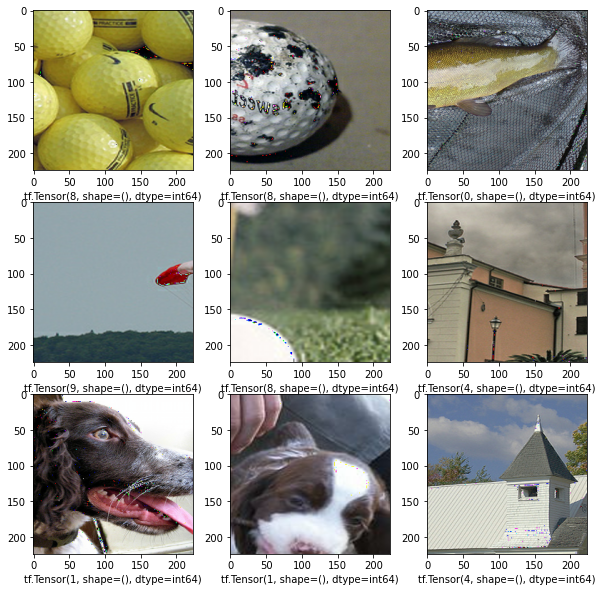

In [13]:
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    image = np.array(train_batch['image'][i, ...]) * np.array(STDDEV_RGB) + np.array(MEAN_RGB)
    plt.imshow(image.astype(np.uint8))
    plt.xlabel(str(train_batch['label'][i]))

### Create Model

the use of `functools.partial` is quite interesting. makes the code much cleaner

In [14]:
class ResNetBlock(nn.Module):
    filters: int
    conv: Any
    norm: Any
    act: Callable
    strides: Tuple[int, int] = (1, 1)
    
    @nn.compact
    def __call__(self, x):
        residual = x
        y = self.conv(self.filters, (3, 3), self.strides)(x)
        y = self.norm()(y)
        y = self.act(y)
        y = self.conv(self.filters, (3, 3))(y)
        y = self.norm()(y)
        if residual.shape != y.shape:
            residual = self.conv(self.filters, (1, 1), self.strides, name='conv_proj')(residual)
            residual = self.norm(name='norm_proj')(residual)
        return self.act(residual + y)


class BottleneckResNetBlock(nn.Module):
    filters: int
    conv: Any
    norm: Any
    act: Callable
    strides: Tuple[int, int] = (1, 1)
    
    @nn.compact
    def __call__(self, x):
        residual = x
        y = self.conv(self.filters, (1, 1))(x)
        y = self.norm()(y)
        y = self.act(y)
        y = self.conv(self.filters, (3, 3), self.strides)(y)
        y = self.norm()(y)
        y = self.act(y)
        y = self.conv(self.filters, (1, 1))(y)
        y = self.norm(scale_init=nn.initializers.zeros)(y)
        
        if residual.shape != y.shape:
            residual = self.conv(self.filters, (1, 1), self.strides, name='conv_proj')(residual)
            residual = self.norm(name='norm_proj')(residual)
        
        return self.act(residual + y)


class ResNet(nn.Module):
    stage_sizes: Sequence[int]
    block_cls: Any
    num_classes: int
    num_filters: int = 64
    dtype: Any = jnp.float32
    act: Callable = nn.relu
    
    @nn.compact
    def __call__(self, x, train: bool = True):
        conv = partial(nn.Conv, use_bias=False, dtype=self.dtype)
        norm = partial(nn.BatchNorm, use_running_average=not train,
                       momentum=0.9, epsilon=1e-5, dtype=self.dtype)
        
        x = conv(self.num_filters, (7, 7), (2, 2), padding=[(3, 3), (3, 3)], name='conv_init')(x)
        x = norm(name='bn_init')(x)
        x = nn.relu(x)
        x = nn.max_pool(x, (3, 3), strides=(2, 2), padding='SAME')
        for i, block_size in enumerate(self.stage_sizes):
            for j in range(block_size):
                strides = (2, 2) if i > 0 and j == 0 else (1, 1)
                x = self.block_cls(self.num_filters * 2 ** i,
                                   strides=strides,
                                   conv=conv,
                                   norm=norm,
                                   act=self.act)(x)
        x = jnp.mean(x, axis=(1, 2))
        x = nn.Dense(self.num_classes, dtype=self.dtype)(x)
        x = jnp.asarray(x, self.dtype)
        return x

ResNet18 = partial(ResNet, stage_sizes=[2, 2, 2, 2], block_cls=ResNetBlock)
ResNet34 = partial(ResNet, stage_sizes=[3, 4, 6, 3], block_cls=ResNetBlock)
ResNet50 = partial(ResNet, stage_sizes=[3, 4, 6, 3], block_cls=BottleneckResNetBlock)

In [15]:
NUM_CLASSES = 1000

model = ResNet50(num_classes=NUM_CLASSES, dtype=jnp.float32)

### Learning rate function

`optax` provides various learning rate function and also a way to mix them together

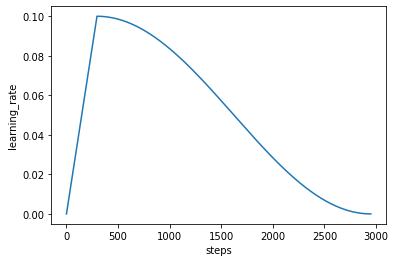

In [16]:
def create_learning_rate_fn(base_learning_rate: float,
                            steps_per_epoch: int,
                            num_epochs: float,
                            warmup_epochs: float):
    warmup_fn = optax.linear_schedule(init_value=0.,
                                      end_value=base_learning_rate,
                                      transition_steps=warmup_epochs*steps_per_epoch)
    cosine_epochs = max(num_epochs - warmup_epochs, 1)
    cosine_fn = optax.cosine_decay_schedule(init_value=base_learning_rate,
                                            decay_steps=cosine_epochs * steps_per_epoch)
    schedule_fn = optax.join_schedules(schedules=[warmup_fn, cosine_fn],
                                       boundaries=[warmup_epochs * steps_per_epoch])
    return schedule_fn


NUM_EPOCHS = 10
steps_per_epoch = train_data_size // config['batch_size']

learning_rate_fn = create_learning_rate_fn(0.1,
                                           steps_per_epoch=steps_per_epoch,
                                           num_epochs=NUM_EPOCHS,
                                           warmup_epochs=NUM_EPOCHS / 10.0)
t = np.arange(steps_per_epoch * NUM_EPOCHS)
lr = learning_rate_fn(t)
plt.plot(t, lr)
plt.xlabel('steps')
plt.ylabel('learning_rate')
plt.show()

### Create TrainState

In order for `BatchNorm` to work, we need to input `{'batch_stats': batch_stats}` when doing `model.apply()`.

`batch_stats` is first initialized when `model.init()`. 

So the `TrainState` needs to be modified in some way. Adding `batch_stats` as a part of `TrainState` can make things a lot easier.

jax also support mixing different floating point precision number when training. But that's for another notebook.

In [17]:
class TrainState(train_state.TrainState):
    batch_stats: Any
    dynamic_scale: flax.optim.DynamicScale


def initialized(rng, image_size, model):
    input_shape = (1, image_size, image_size, 3)
    @jax.jit
    def init(*args):
        return model.init(*args)
    variables = init({'params': rng}, jnp.ones(input_shape, model.dtype))
    return variables['params'], variables['batch_stats']


def create_train_state(rng, model, image_size, learning_rate_fn):
    params, batch_stats = initialized(rng, image_size, model)
    tx = optax.sgd(learning_rate=learning_rate_fn,
                   momentum=config['momentum'],
                   nesterov=True)
    state = TrainState.create(apply_fn=model.apply,
                              params=params,
                              tx=tx,
                              batch_stats=batch_stats,
                              dynamic_scale=None)
    return state


rng = jax.random.PRNGKey(666)
state = create_train_state(rng, model, config['image_size'], learning_rate_fn)
print(state)

TrainState(step=0, apply_fn=<bound method Module.apply of ResNet(
    # attributes
    stage_sizes = [3, 4, 6, 3]
    block_cls = BottleneckResNetBlock
    num_classes = 1000
    num_filters = 64
    dtype = float32
    act = relu
)>, params=FrozenDict({
    BottleneckResNetBlock_0: {
        BatchNorm_0: {
            bias: DeviceArray([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                         0., 0., 0., 0.], dtype=float32),
            scale: DeviceArray([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
                         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
                         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
                         

### Prepare data

In [24]:
def prepare_tf_data(xs):
    def _prepare(x):
        return x._numpy()
    return jax.tree_map(_prepare, xs)


def create_train_iter():
    train_ds = create_train_ds()
    train_iter = map(prepare_tf_data, train_ds)
    return train_iter


def create_test_iter():
    test_ds = create_test_ds()
    test_iter = map(prepare_tf_data, test_ds)
    return test_iter


train_iter = create_train_iter()
test_iter = create_test_iter()

INFO:absl:Constructing tf.data.Dataset imagenette for split train, from /home/kiddos/tensorflow_datasets/imagenette/full-size-v2/1.0.0
INFO:absl:Constructing tf.data.Dataset imagenette for split validation, from /home/kiddos/tensorflow_datasets/imagenette/full-size-v2/1.0.0


In [25]:
train_batch = next(train_iter)
{k: (v.shape, v.dtype) for k, v in train_batch.items()}

{'image': ((32, 224, 224, 3), dtype('float32')),
 'label': ((32,), dtype('int64'))}

In [26]:
test_batch = next(test_iter)
{k: (v.shape, v.dtype) for k, v in test_batch.items()}

{'image': ((32, 224, 224, 3), dtype('float32')),
 'label': ((32,), dtype('int64'))}

### Train Step

make sure to use `@jax.jit`. this will make things much faster.

Note: when using `@jax.jit`, make sure the function's parameters are support by jax (so so function, no custom objects), else jax might try to create different jit version of the function very time, which will make this really slow.

In [27]:
@jax.jit
def cross_entropy_loss(logits, labels):
    one_hot_labels = common_utils.onehot(labels, num_classes=NUM_CLASSES)
    cross_entropy = optax.softmax_cross_entropy(logits=logits, labels=one_hot_labels)
    return jnp.mean(cross_entropy)


@jax.jit
def compute_metrics(logits, labels):
    loss = cross_entropy_loss(logits, labels)
    accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
    metrics = {
        'loss': loss,
        'accuracy': accuracy,
    }
    return metrics


@jax.jit
def loss_fn(params, batch, state):
    logits, new_model_state = state.apply_fn(
        {'params': params, 'batch_stats': state.batch_stats},
        batch['image'],
        mutable=['batch_stats'])
    loss = cross_entropy_loss(logits, batch['label'])
    weight_penalty_params = jax.tree_leaves(params)
    weight_decay = 1e-4
    weight_l2 = sum([jnp.sum(x ** 2) for x in weight_penalty_params if x.ndim > 1])
    weight_penalty = weight_decay * 0.5 * weight_l2
    loss = loss + weight_penalty
    return loss, (new_model_state, logits)


@jax.jit
def update_state(state, grads, batch_stats):
    return state.apply_gradients(grads=grads, batch_stats=batch_stats)


def train_step(state, batch, learning_rate_fn):
    step = state.step
    lr = learning_rate_fn(step)
    
    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    aux, grads = grad_fn(state.params, batch, state)
    new_model_state, logits = aux[1]
    # new_state = state.apply_gradients(grads=grads, batch_stats=new_model_state['batch_stats'])
    new_state = update_state(state, grads, new_model_state['batch_stats'])
    
    metrics = compute_metrics(logits, batch['label'])
    metrics['learning_rate'] = lr
    return new_state, metrics


test_state, metrics = train_step(state, train_batch, learning_rate_fn)
print(test_state)
print(metrics)

TrainState(step=DeviceArray(1, dtype=int32), apply_fn=<bound method Module.apply of ResNet(
    # attributes
    stage_sizes = [3, 4, 6, 3]
    block_cls = BottleneckResNetBlock
    num_classes = 1000
    num_filters = 64
    dtype = float32
    act = relu
)>, params=FrozenDict({
    BottleneckResNetBlock_0: {
        BatchNorm_0: {
            bias: DeviceArray([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                         0., 0., 0., 0.], dtype=float32),
            scale: DeviceArray([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
                         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
                         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,

In [28]:
%timeit train_step(state, train_batch, learning_rate_fn)

149 ms ± 5.32 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [29]:
def eval_step(state, batch):
    variables = {'params': state.params, 'batch_stats': state.batch_stats}
    logits = state.apply_fn(variables, batch['image'], train=False, mutable=False)
    return compute_metrics(logits, batch['label'])


def train_and_evaluate(epochs, state=None):
    steps_per_epoch = train_data_size // config['batch_size']
    steps_for_eval = test_data_size // config['batch_size']
    learning_rate_fn = create_learning_rate_fn(0.1,
                                               steps_per_epoch=steps_per_epoch,
                                               num_epochs=epochs,
                                               warmup_epochs=epochs / 10.0)
    rng = jax.random.PRNGKey(666)
    if not state:
        model = ResNet34(num_classes=NUM_CLASSES, dtype=jnp.float32)
        state = create_train_state(rng, model, config['image_size'], learning_rate_fn)
    
    train_iter = create_train_iter()
    test_iter = create_test_iter()
    
    logging.info('Initial compilation')
    for epoch in range(epochs):
        train_metrics = []
        for step, batch in tqdm(zip(range(steps_per_epoch), train_iter)):
            state, metrics = train_step(state, batch, learning_rate_fn)
            train_metrics.append(metrics)
        train_loss = jnp.average([m['loss'] for m in train_metrics])
        train_accuracy = jnp.average([m['accuracy'] for m in train_metrics])
        
        eval_metrics = []
        for _ in range(steps_for_eval):
            eval_batch = next(test_iter)
            metrics = eval_step(state, eval_batch)
            eval_metrics.append(metrics)
        ## eval_metrics = common_utils.get_metrics(eval_metrics)
        eval_loss = jnp.average([m['loss'] for m in eval_metrics])
        eval_accuracy = jnp.average([m['accuracy'] for m in eval_metrics])
        logging.info('epoch: %d, train loss: %.4f, accuracy: %.2f, eval loss: %.4f, accuracy: %.2f',
                     epoch, train_loss, train_accuracy, eval_loss, eval_accuracy)
    return state


trained_state = train_and_evaluate(10)

INFO:absl:Constructing tf.data.Dataset imagenette for split train, from /home/kiddos/tensorflow_datasets/imagenette/full-size-v2/1.0.0
INFO:absl:Constructing tf.data.Dataset imagenette for split validation, from /home/kiddos/tensorflow_datasets/imagenette/full-size-v2/1.0.0
INFO:absl:Initial compilation
295it [00:46,  6.37it/s]
INFO:absl:epoch: 0, train loss: 2.4461, accuracy: 0.23, eval loss: 2.0747, accuracy: 0.27
295it [00:39,  7.45it/s]
INFO:absl:epoch: 1, train loss: 1.8602, accuracy: 0.37, eval loss: 1.8999, accuracy: 0.40
295it [00:39,  7.48it/s]
INFO:absl:epoch: 2, train loss: 1.6373, accuracy: 0.45, eval loss: 1.5755, accuracy: 0.48
295it [00:39,  7.56it/s]
INFO:absl:epoch: 3, train loss: 1.4364, accuracy: 0.53, eval loss: 1.2023, accuracy: 0.61
295it [00:39,  7.43it/s]
INFO:absl:epoch: 4, train loss: 1.2824, accuracy: 0.58, eval loss: 1.1363, accuracy: 0.63
295it [00:39,  7.46it/s]
INFO:absl:epoch: 5, train loss: 1.1550, accuracy: 0.63, eval loss: 0.9581, accuracy: 0.69
295it

In [30]:
trained_state = train_and_evaluate(10, state=trained_state)

INFO:absl:Constructing tf.data.Dataset imagenette for split train, from /home/kiddos/tensorflow_datasets/imagenette/full-size-v2/1.0.0
INFO:absl:Constructing tf.data.Dataset imagenette for split validation, from /home/kiddos/tensorflow_datasets/imagenette/full-size-v2/1.0.0
INFO:absl:Initial compilation
295it [00:39,  7.44it/s]
INFO:absl:epoch: 0, train loss: 0.8223, accuracy: 0.74, eval loss: 0.6671, accuracy: 0.79
295it [00:40,  7.34it/s]
INFO:absl:epoch: 1, train loss: 0.8040, accuracy: 0.74, eval loss: 0.6755, accuracy: 0.78
295it [00:39,  7.42it/s]
INFO:absl:epoch: 2, train loss: 0.8223, accuracy: 0.73, eval loss: 0.6739, accuracy: 0.79
295it [00:39,  7.46it/s]
INFO:absl:epoch: 3, train loss: 0.7936, accuracy: 0.75, eval loss: 0.6728, accuracy: 0.79
295it [00:39,  7.48it/s]
INFO:absl:epoch: 4, train loss: 0.8170, accuracy: 0.73, eval loss: 0.6712, accuracy: 0.79
295it [00:39,  7.52it/s]
INFO:absl:epoch: 5, train loss: 0.8167, accuracy: 0.74, eval loss: 0.6802, accuracy: 0.78
295it

In [32]:
from flax.training import checkpoints

def save_checkpoint(state, workdir):
    if jax.process_index() == 0:
        step = int(state.step)
        checkpoints.save_checkpoint(workdir, state, step, keep=3)

save_checkpoint(trained_state, f'./models/resnet50')

INFO:absl:Saving checkpoint at step: 5900
INFO:absl:Saved checkpoint at models/resnet50/checkpoint_5900
